# Benchmark CLgen Training Time
Plot training times as a function of network size.

In [1]:
# preamble
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from time import time
from labm8 import fs
from labm8 import system
from labm8.time import nowstr

import clgen
from clgen import corpus
from clgen import dbutil
from clgen import sampler
from clgen import model
from clgen import preprocess

**Experimental setup:**

In [3]:
rnn_sizes = [4, 8, 16] #[256, 512, 1024, 2048]
corpus_opts = {
    "path": "~/data/tiny" #"~/data/github"
}
training_opts = {
    "model_type": "lstm",
    "num_layers": 2, #3,
    "max_epochs": 1 #50
}

c = corpus.Corpus.from_json(corpus_opts)
print("Corpus size:", c.size)
print("Vocab size: ", c.vocab_size)
print()
clgen.platform_info()

Corpus size: 773245
Vocab size:  92

CLgen:      0.2.1 (with OpenCL)
Platform:   Darwin
Memory:     16384 MB

Device:     GPU Intel(R) Iris(TM) Graphics 6100
Compute #.: 48
Frequency:  1100 HZ
Memory:     1536 MB
Driver:     1.2(Oct 19 2016 00:25:08)


**Experimental methodology:**

In [12]:
def benchmark_training_time(model):
    """ train model and return elapsed time in seconds """
    model.cache.empty()  # clear checkpoint cache    
    tstart = time()  # start timer
    model.train(quiet=True)  # train model
    return time() - tstart

**Experimental results:**

In [13]:
data_file = "./benchmark-{host}.json".format(host=system.HOSTNAME)
fs.rm(data_file)  # reset experimental data
data = clgen.load_json_file(data_file, must_exist=False)

for rnn_size in rnn_sizes:
    key = str(rnn_size)
    if key not in data:
        print("collecting result for", rnn_size, "...")
        training_opts["rnn_size"] = rnn_size
        data[key] = benchmark_training_time(model.from_json({
            "corpus": corpus_opts,
            "train_opts": training_opts
        }))
    print("result", rnn_size, "{:.1f}".format(data[key]), "seconds")
    clgen.write_file(data_file, clgen.format_json(data))
print("done", nowstr())
data

collecting result for 4
result 4 37.3 seconds
collecting result for 8
result 8 37.4 seconds
collecting result for 16
result 16 41.8 seconds
done 2016-12-15 00:22:53


{'16': 41.83615493774414, '4': 37.28904891014099, '8': 37.41653800010681}

**Evaluation:**

(4, 8, 16)
(15.877464056015015, 17.752957105636597, 40.19394898414612)


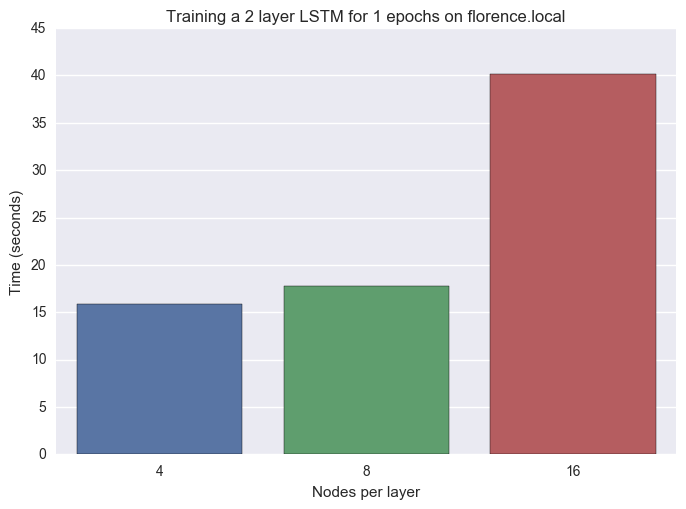

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

x, y = zip(*[(int(x), data[x]) for x in sorted(data.keys(), key=lambda x: int(x))])
print(x)
print(y)
sns.barplot(x, y)
plt.title("Training a {nlayers} layer {model_type} for {epochs} epochs on {host}"
          .format(nlayers=training_opts["num_layers"],
                  model_type=training_opts["model_type"].upper(),
                  epochs=training_opts["max_epochs"],
                  host=system.HOSTNAME))
plt.xlabel("Nodes per layer")
plt.ylabel("Time (seconds)")